In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from prettytable import PrettyTable
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")

In [9]:
train_data = pd.read_csv('data/multilabelClassification/train.csv')
test_data = pd.read_csv('data/multilabelClassification/test.csv')
dev_data = pd.read_csv('data/multilabelClassification/dev.csv')

In [10]:
train_data.head()

,Description,Commenting,Ogling/Facial Expressions/Staring,Touching /Groping
0,"Was walking along crowded street, holding mums...",0,0,1
1,This incident took place in the evening.I was ...,0,1,0
2,I WAS WAITING FOR THE BUS. A MAN CAME ON A BIK...,1,0,0
3,Incident happened inside the train,0,0,0
4,I witnessed an incident when a chain was bruta...,0,0,0


In [11]:
tag_combination = {(1,1,1):0,(1,1,0):0,(1,0,1):0,(1,0,0):0,(0,1,1):0,(0,1,0):0,(0,0,1):0,(0,0,0):0}

for n in range(len(train_data)):
    c = train_data.iloc[n]['Commenting']
    o = train_data.iloc[n]['Ogling/Facial Expressions/Staring']
    g = train_data.iloc[n]['Touching /Groping']
    tag_combination[(c,o,g)]+=1

In [12]:
pt = PrettyTable()

pt.field_names = [train_data.columns[1],train_data.columns[2],train_data.columns[3],"Count"]
for comb in tag_combination:
    pt.add_row([comb[0],comb[1],comb[2],tag_combination[comb]])
print(pt)

+------------+-----------------------------------+-------------------+-------+
| Commenting | Ogling/Facial Expressions/Staring | Touching /Groping | Count |
+------------+-----------------------------------+-------------------+-------+
|     1      |                 1                 |         1         |  243  |
|     1      |                 1                 |         0         |  600  |
|     1      |                 0                 |         1         |  333  |
|     1      |                 0                 |         0         |  1644 |
|     0      |                 1                 |         1         |  145  |
|     0      |                 1                 |         0         |  538  |
|     0      |                 0                 |         1         |  1445 |
|     0      |                 0                 |         0         |  2253 |
+------------+-----------------------------------+-------------------+-------+


In [13]:
row_with_html_tag=0
for row in tqdm(range(len(train_data['Description']))):
    searchObject = re.search(r'<.*?>',train_data['Description'][row])
    if searchObject!=None:
        row_with_html_tag+=1
        train_data['Description'][row]=re.sub(r'<.*?>',"",train_data['Description'][row])   

if row_with_html_tag==0:
    print("No comment with html tags")
else:
    print("Number of rows with html tags -> {0}".format(row_with_html_tag))

100%|██████████| 7201/7201 [00:00<00:00, 42582.52it/s]

No comment with html tags


In [14]:
row_with_numbers_special_char=0
for row in tqdm(range(len(train_data['Description']))):
    searchObject = re.search(r'[^a-zA-Z ]',train_data['Description'][row])
    if searchObject!=None:
        row_with_numbers_special_char+=1
        train_data['Description'][row] = re.sub(r'[^a-zA-Z ]',"",train_data['Description'][row])
        
if row_with_numbers_special_char==0:
    print("No comment with numbers and special characters")
else:
    print("Number of rows with numbers and special characters -> {0}".format(row_with_numbers_special_char))

100%|██████████| 7201/7201 [00:00<00:00, 8578.73it/s]

Number of rows with numbers and special characters -> 5214


In [15]:
for row in tqdm(range(len(train_data['Description']))):
    train_data['Description'][row] = train_data['Description'][row].lower() 

100%|██████████| 7201/7201 [00:00<00:00, 7724.21it/s]


In [16]:
stop_words = set(stopwords.words('english'))
def rmv_stop_words(x):
    temp = ""
    for word in x.split(" "):
        if word not in stop_words:
            temp += word + " "
    return temp
   

In [17]:
for row in tqdm(range(len(train_data['Description']))):
    train_data['Description'][row] = rmv_stop_words(train_data['Description'][row])

100%|██████████| 7201/7201 [00:01<00:00, 6840.73it/s]


In [18]:
train_data

,Description,Commenting,Ogling/Facial Expressions/Staring,Touching /Groping
0,walking along crowded street holding mums hand...,0,0,1
1,incident took place eveningi metro two guys st...,0,1,0
2,waiting bus man came bike offering liftvto you...,1,0,0
3,incident happened inside train,0,0,0
4,witnessed incident chain brutally snatched eld...,0,0,0
...,...,...,...,...
7196,person near construction site probably laborer...,0,1,0
7197,threatened making inappropriate conversationth...,1,0,0
7198,happened morning university metro station guys...,1,0,0
7199,one day aunt returniec frm office shaunt e fo...,0,0,0


In [19]:
train_data_tokenized = []
for row in tqdm(range(len(train_data['Description']))):
    train_data_tokenized.append(word_tokenize(train_data['Description'][row]))

100%|██████████| 7201/7201 [00:01<00:00, 5125.61it/s]


In [20]:
word_net_lemmatizer = WordNetLemmatizer()
for i in tqdm(range(len(train_data_tokenized))):
    for j in range(len(train_data_tokenized[i])):
        train_data_tokenized[i][j] = word_net_lemmatizer.lemmatize(train_data_tokenized[i][j],pos="v")

100%|██████████| 7201/7201 [00:02<00:00, 3084.83it/s]


In [21]:
description_text = ""
for i in tqdm(range(len(train_data_tokenized))):
    for j in range(len(train_data_tokenized[i])):
        description_text += train_data_tokenized[i][j] + " "

100%|██████████| 7201/7201 [00:00<00:00, 172312.93it/s]


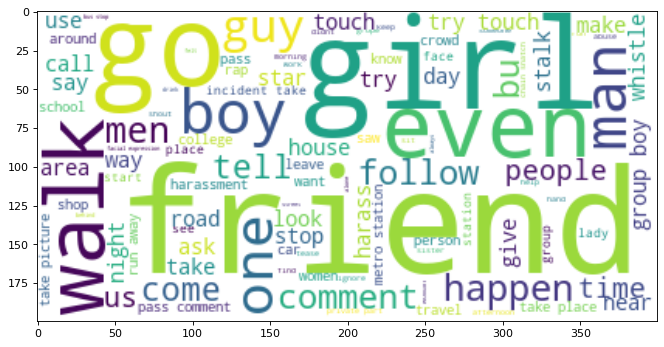

In [22]:
wordcloud = WordCloud(max_words = 100,background_color="white").generate(description_text)
plt.figure(figsize=(10, 10), dpi=80)
plt.imshow(wordcloud,interpolation="bilinear")
plt.show()

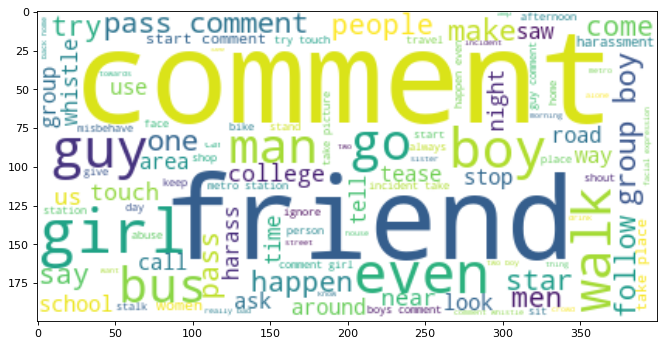

In [23]:
description_with_tag_commenting = []
for i in range(len(train_data['Commenting'])):
    if train_data['Commenting'][i] == 1:
        description_with_tag_commenting.append(i)

description_text_commenting = ""
for i in description_with_tag_commenting:
    for j in train_data_tokenized[i]:
        description_text_commenting += j + " "

wordcloud = WordCloud(max_words = 100,background_color="white").generate(description_text_commenting)
plt.figure(figsize=(10, 10), dpi=80)
plt.imshow(wordcloud,interpolation="bilinear")
plt.show()

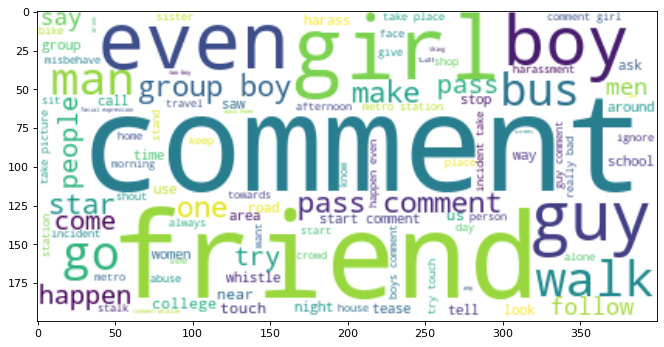

In [24]:
description_with_tag_ogling = []
for i in range(len(train_data['Ogling/Facial Expressions/Staring'])):
    if train_data['Commenting'][i] == 1:
        description_with_tag_ogling.append(i)  

description_text_ogling = ""
for i in description_with_tag_ogling:
    for j in train_data_tokenized[i]:
        description_text_ogling += j + " "

wordcloud = WordCloud(max_words = 100,background_color="white").generate(description_text_ogling)
plt.figure(figsize=(10, 10), dpi=80)
plt.imshow(wordcloud,interpolation="bilinear")
plt.show()

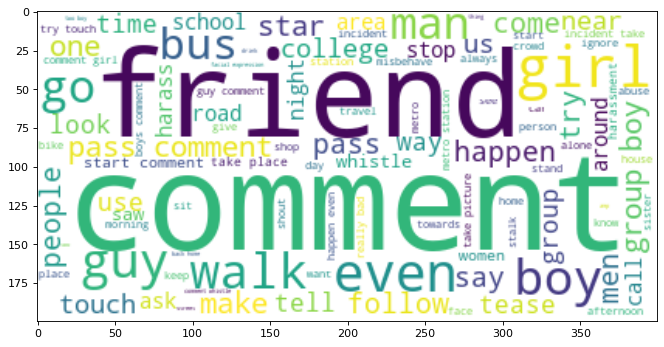

In [25]:
description_with_tag_touching = []
for i in range(len(train_data['Touching /Groping'])):
    if train_data['Commenting'][i] == 1:
        description_with_tag_touching.append(i) 
        
description_text_touching = ""
for i in description_with_tag_touching:
    for j in train_data_tokenized[i]:
        description_text_touching += j + " "
        
wordcloud = WordCloud(max_words = 100,background_color="white").generate(description_text_touching)
plt.figure(figsize=(10, 10), dpi=80)
plt.imshow(wordcloud,interpolation="bilinear")
plt.show()

In [26]:
data_with_tags = []
data_with_tags.extend(description_with_tag_commenting)
data_with_tags.extend(description_with_tag_ogling)
data_with_tags.extend(description_with_tag_touching)

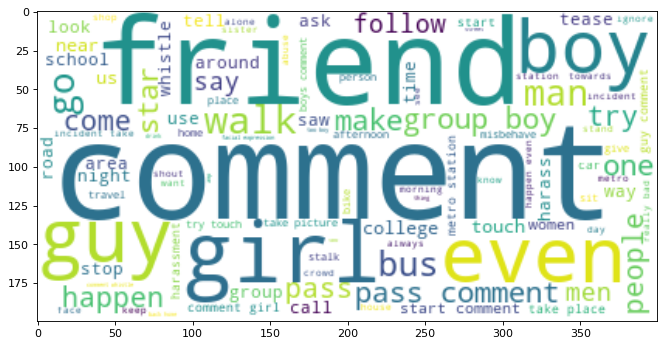

In [27]:
data_with_no_tags = []
description_text_without_tags = ""
for i in range(len(train_data_tokenized)):
    if i in data_with_tags:
        data_with_no_tags.append(i)
        for j in train_data_tokenized[i]:
            description_text_without_tags += j + " "

wordcloud = WordCloud(max_words = 100,background_color="white").generate(description_text_without_tags)
plt.figure(figsize=(10, 10), dpi=80)
plt.imshow(wordcloud,interpolation="bilinear")
plt.show()